## Insight Project
1. [Image to Text with OpenCV](#im2txt)
2. [Text Summarization](#txtsum)
   1. [`gensim` Summarizer](#gensim)
   2. [Similarity Summarizer](#similarity)



### 1. Image to Text with OpenCV  <a class="anchor" id="im2txt"></a>

In [48]:
import cv2 as cv
import numpy as np
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

Preprocessing the image

In [51]:
img = cv.imread('tst_img.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv.filter2D(gray, -1, sharpen_kernel)
#thresh = cv.threshold(sharpen, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]


In [56]:
img = Image.fromarray(sharpen)
img.save('fltr_img.png')
img = cv2.imread('fltr_img.png')
denoise = cv2.fastNlMeansDenoisingColored(img, None, 10,10,7,21)
raw_text = pytesseract.image_to_string(img)


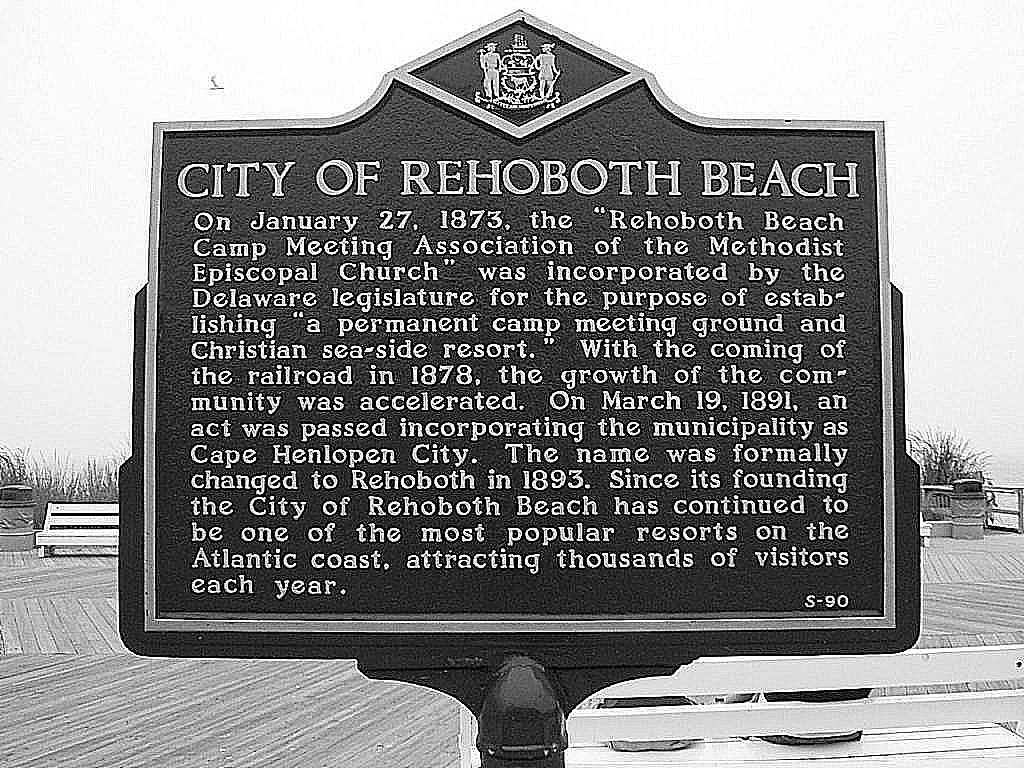

In [54]:
display(Image.open('fltr_img.png'))


In [57]:
raw_text

'CITY OF REHOBOTH BEACH |\n\n| On January 27, 1873, the “Rehoboth Beach\nCamp Meeting Association of the Methodist\nEpiscopal Church” was incorporated by the\nDelaware legislature for the purpose of estab~\nlishing “a permanent camp meeting ground and\nChristian sea-side resort.” With the coming of\nthe. railroad in 1878, the growth of the com-~\nmunity was accelerated. On March 19, 1891, an\nact was passed incorporating the municipality as\nCape Henlopen City. The name was formally\nchanged to Rehoboth in 1893. Since its founding\nthe City of Rehoboth Beach has continued to\nbe one of the most popular resorts on the\nAtlantic coast, attracting thousands of visitors\neach year.'


### 2. Text Summarization  <a class="anchor" id="txtsum"></a>

#### A. `gensim` Summarizer  <a class="anchor" id="gensim"></a>

Let's have some simple summaries to being with: `summary_0`, `summary_1` and `summary_2`.

Preprocessing the extracted text

In [132]:
txt = re.sub(r'\n', ' ', raw_text)
txt = re.sub(r'\[[0-9]*\]', ' ', txt)
txt = re.sub(r'\s+', ' ', txt)
txt = re.sub(r'\s+', ' ', txt)


In [133]:
from gensim.summarization import summarize
summary_0 = summarize(txt)

In [134]:
summary_0

'CITY OF REHOBOTH BEACH | | On January 27, 1873, the “Rehoboth Beach Camp Meeting Association of the Methodist Episcopal Church” was incorporated by the Delaware legislature for the purpose of estab~ lishing “a permanent camp meeting ground and Christian sea-side resort.” With the coming of the.'

#### B. Similarity Summarizer  <a class="anchor" id="similarity"></a>

In [120]:
import re
import nltk
import heapq
import requests 
import urllib
import networkx as nx
import bs4 as bs
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

In [121]:
sum_len = 3

In [122]:
formatted_raw_text = re.sub('[^a-zA-Z]', ' ', raw_text)
sentence_list = nltk.sent_tokenize(raw_text)
stop_words = stopwords.words('english')

word_frequencies = {}
for word in nltk.word_tokenize(formatted_raw_text):
    if word not in stop_words:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1


maximum_frequncy = max(word_frequencies.values())

for word in word_frequencies.keys():
    word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)


sentence_scores = {}
for sent in sentence_list:
    for word in nltk.word_tokenize(sent.lower()):
        if word in word_frequencies.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]


summary_sentences = heapq.nlargest(sum_len, sentence_scores, key = sentence_scores.get)

summary_1 = ' '.join(summary_sentences)
# with open('summary_1.txt', 'w') as text_file:
#     for i in  summary:
#         text_file.write(i)

In [129]:
summary_1

'Since its founding\nthe City of Rehoboth Beach has continued to\nbe one of the most popular resorts on the\nAtlantic coast, attracting thousands of visitors\neach year. railroad in 1878, the growth of the com-~\nmunity was accelerated. On March 19, 1891, an\nact was passed incorporating the municipality as\nCape Henlopen City.'

In [124]:
def sentence_smlrty(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    all_words = list(set(sent1 + sent2))
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1        
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    return 1 - cosine_distance(vector1, vector2)


def build_smlrty_mtrx(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences))) 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: 
                continue 
            similarity_matrix[idx1][idx2] = sentence_smlrty(sentences[idx1], sentences[idx2],
                                                            stop_words)
            if np.isnan(similarity_matrix[idx1][idx2]):
                similarity_matrix[idx1][idx2] = 0    
    return similarity_matrix

In [125]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
summarize_text = []

file = open('article.txt', "r")
article = file.readlines()[0].split(". ")
sentences = []

for sentence in article:
    sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
sentences.pop() 
sentence_smlrty_mtrx = build_smlrty_mtrx(sentences, stop_words)
sentence_smlrty_grph = nx.from_numpy_array(sentence_smlrty_mtrx)
scores = nx.pagerank(sentence_smlrty_grph, max_iter = 150)    
ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)      

for i in range(sum_len):
    summarize_text.append(" ".join(ranked_sentence[i][1]))
summary_2 = ' '.join(summarize_text)

# with open('summary_2.txt', 'w') as text_file:
#     for i in  summarize_text:
#         text_file.write(i)

In [128]:
summary_2

'CITY OF REHOBOTH BEACH | | On January 27, 1873, the “Rehoboth Beach Camp Meeting Association of the Methodist Episcopal Church” was incorporated by the Delaware legislature for the purpose of estab~ lishing “a permanent camp meeting ground and Christian sea-side resort.” With the coming of the The name was formally changed to Rehoboth in 1893 On March 19, 1891, an act was passed incorporating the municipality as Cape Henlopen City'